## Modeling Zmp/CoM trajectory by using pinocchio

### Preproc

In [14]:
import numpy as np
import pinocchio as pin
import example_robot_data
import meshcat.geometry as g
import meshcat.transformations as tf
from IPython.display import IFrame, display
from pinocchio.visualize import MeshcatVisualizer

from Factor import FactorGraph, Factor, zero, eye
from BothLegs import LeftLeg, RightLeg
from Plotter import Plotter
from Talos import Talos
from FootSteps import *
from Factor import *
from CoM import *
from Zmp import *

In Pinocchio a frame is an anchor point or coordinate system associated with a link, joint, etc.

The code below shows through all the frames in the model and prints their number and name.

#### Talos

In [15]:
name_robot = "talos"

robot = example_robot_data.load(name_robot)
model = robot.model
data = robot.data

for i, f in enumerate(model.frames):
    print(f"{i}: {f.name}")

0: universe
1: root_joint
2: base_link
3: leg_left_1_joint
4: leg_left_1_link
5: leg_left_2_joint
6: leg_left_2_link
7: leg_left_3_joint
8: leg_left_3_link
9: leg_left_4_joint
10: leg_left_4_link
11: leg_left_5_joint
12: leg_left_5_link
13: leg_left_6_joint
14: leg_left_6_link
15: leg_left_sole_fix_joint
16: left_sole_link
17: leg_right_1_joint
18: leg_right_1_link
19: leg_right_2_joint
20: leg_right_2_link
21: leg_right_3_joint
22: leg_right_3_link
23: leg_right_4_joint
24: leg_right_4_link
25: leg_right_5_joint
26: leg_right_5_link
27: leg_right_6_joint
28: leg_right_6_link
29: leg_right_sole_fix_joint
30: right_sole_link
31: torso_1_joint
32: torso_1_link
33: torso_2_joint
34: torso_2_link
35: arm_left_1_joint
36: arm_left_1_link
37: arm_left_2_joint
38: arm_left_2_link
39: arm_left_3_joint
40: arm_left_3_link
41: arm_left_4_joint
42: arm_left_4_link
43: arm_left_5_joint
44: arm_left_5_link
45: arm_left_6_joint
46: arm_left_6_link
47: arm_left_7_joint
48: arm_left_7_link
49: wrist_l

#### CoM for robot in pin

In [16]:
pin.framesForwardKinematics(model, data, robot.q0)
robot_com = pin.centerOfMass(model, data, robot.q0)
print (f"required CoM for {name_robot}: {robot_com[2]}")

required CoM for talos: 0.8766813898929622


#### Angular momentum of rotation



It should be noted right away that rotational motion cannot be described because the point is static and rotation cannot be taken into account.

Here is the formula for the angular momentum of rotation.

$$
\dot{L}_c = \sum_{i \in \text{contacts}} (p_i - c) \times f_i
$$

---

We will assume that it is equal to 0. So here updated angular momentum of rotation:

$$
\dot{L}_c = 0
$$

---

Also let's assume that height is constant:

$$
c \cdot e_z = h
$$

---

### 0. FootSteps

Let's define the robot's footstep sequence by initializing the `FootSteps` object with the initial foot positions. Let's use `add_phase` to set the duration, support foot, and, if needed, the new swing foot position for each phase. This way, let's create an alternating pattern of double and single support, forming the robot's walking trajectory.

In [17]:
footsteps = FootSteps([.0, -.1], [.0, .1])
footsteps.add_phase(.3, 'none')
footsteps.add_phase(.7, 'left', [.1, .1])
footsteps.add_phase(.1, 'none')
footsteps.add_phase(.7, 'right', [.2, -.1])
footsteps.add_phase(.1, 'none')
footsteps.add_phase(.7, 'left', [.3, .1])
footsteps.add_phase(.1, 'none')
footsteps.add_phase(.7, 'right', [.4, -.1])
footsteps.add_phase(.1, 'none')
footsteps.add_phase(.7, 'left', [.5, .1])
footsteps.add_phase(.1, 'none')
footsteps.add_phase(.7, 'right', [.5, -.1])
footsteps.add_phase(.5, 'none')

### 1. Zero-tilting Moment Point or Zmp



If we consider each foot separately, we can calculate a "local" CoP for each foot (left and right CoP). But the CoP for the entire robot+support system is always the same. It is important to note that in this project, Zmp = CoP will be assumed (such an assumption is possible). It is important to note that CoP, like Zmp, can only be 1:

$$
p = \int_{(x, y) \in \mathcal{S}}
\begin{bmatrix}
x \\
y
\end{bmatrix}
f_z(x, y)\,\mathrm{d}x\,\mathrm{d}y
$$

---

Let's write the formula of Zero-tilting moment point or Zmp.

$$
\tau_z \times e_z = \left[ \sum_{i \in \text{contacts}} (p_i - z) \times f_i \right] \times e_z = 0
$$

---

In [18]:
def compute_zmp_at_time(footsteps, t):
    foot = footsteps.get_phase_type(t)
    left_pos = footsteps.get_left_position(t)
    right_pos = footsteps.get_right_position(t)
    
    if foot == 'left':
        result = np.array(right_pos)
    elif foot == 'right':
        result = np.array(left_pos)
    else: # two feet on ground
        result = np.array([(left_pos[0] + right_pos[0]) / 2, 
                          (left_pos[1] + right_pos[1]) / 2])
    return result

def zmp_trajectory_function(t):
    result = compute_zmp_at_time(footsteps, t)
    return [result[0], result[1]]

### 2. LIPM / Linear inverted pendulum mode:


**Assumptions:**
- Solid body.
- Translational motion is described by CoM.
- Constant center of mass (CoM) height  

**Equation of motion for LIMP:**
$$
\ddot{c} = \omega^2 (c - z) + g
$$

where:  
- $\omega$ is a constant  
- $z$ is the zero moment point (ZMP)  
- In the horizontal plane, $+g$ is usually omitted

---

So let's simplify: 
$$
\ddot{c} = \omega^2 (c - z)
$$




In [19]:
def setup_limp_parameters(footsteps, com_z_nominal=0.9):
    dt = 0.005
    t_end = footsteps.timetime[-1]
    g = 9.8
    N = int(t_end / dt)
    L = com_z_nominal / g
    
    params = {
        'dt': dt,
        't_end': t_end,
        'com_z': com_z_nominal,
        'g': g,
        'N': N,
        'L': L
    }
    
    print(f"CoM height: {com_z_nominal:.3f} m")
    print(f"Characteristic length L = h/g: {L:.3f} m")
    print(f"Number of time steps: {N}")
    print(f"Time step: {dt:.3f} sec")
    
    return params

def setup_dynamics_matrices(dt, L):
    # State transition matrix [c, ċ, c̈] -> [c', ċ', c̈']
    M1 = np.array([[1, dt, 0], 
                   [0, 1, dt], 
                   [0, 0, 1]])
    
    # Single matrix
    M2 = np.array([[1, 0, 0], 
                   [0, 1, 0], 
                   [0, 0, 1]])
    
    # Matrix for ZMP extraction: z = c - L*c̈
    Mc = np.array([[1, 0, -L]])
    
    return M1, M2, Mc

limp_params = setup_limp_parameters(footsteps, robot_com[2])
M1, M2, Mc = setup_dynamics_matrices(limp_params['dt'], limp_params['L'])

CoM height: 0.877 m
Characteristic length L = h/g: 0.089 m
Number of time steps: 1100
Time step: 0.005 sec


### 3. Trajectory CoM

In [20]:
def solve_com_trajectory_direction(footsteps, direction, limp_params, M1, M2, Mc):
    """
    Solves the CoM trajectory for one direction (0=X, 1=Y)
    
    LCQP problem statement:
    min ||Ax - b||² subject to Cx = d
    
    Constraints:
    1. Dynamics: x_{k+1} = M1 * x_k
    2. ZMP: z_k = c_k - L * c̈_k
    """
    
    direction_name = "X" if direction == 0 else "Y"
    print(f"\nSolving CoM trajectory for direction {direction_name}:")
    
    N = limp_params['N']
    dt = limp_params['dt']
    nx = 3  # state dimension [c, ċ, c̈]
    
    f = FactorGraph(nx, N)
    
    # Add dynamics constraints
    constraint_count = 0
    for k in range(N-1):
        f.add_factor_constraint([Factor(k, M1), Factor(k+1, -M2)], zero(3))
        constraint_count += 1
    
    # Add ZMP constraints
    zmp_constraint_count = 0
    zmp_refs = []
    
    for k in range(N):
        t = dt * k
        zmp_ref = compute_zmp_at_time(footsteps, t)[direction]
        zmp_refs.append(zmp_ref)
        f.add_factor_constraint([Factor(k, Mc)], eye(1) * zmp_ref)
        zmp_constraint_count += 1
    
    print(f"{zmp_constraint_count} ZMP constraints added")
    opt_solution = f.solve()
    trajectory = np.reshape(opt_solution[0::3], len(opt_solution[0::3]))
    
    return trajectory, opt_solution, zmp_refs

def generate_com_trajectories(footsteps, limp_params, M1, M2, Mc):
    
    # Solve for X direction
    x_traj, x_opt, x_zmp_refs = solve_com_trajectory_direction(
        footsteps, 0, limp_params, M1, M2, Mc)
    
    # Solve for Y direction  
    y_traj, y_opt, y_zmp_refs = solve_com_trajectory_direction(
        footsteps, 1, limp_params, M1, M2, Mc)
    
    
    trajectories = {
        'x_traj': x_traj,
        'y_traj': y_traj,
        'x_opt': x_opt,
        'y_opt': y_opt,
        'x_zmp_refs': x_zmp_refs,
        'y_zmp_refs': y_zmp_refs
    }
    
    return trajectories

com_trajectories = generate_com_trajectories(footsteps, limp_params, M1, M2, Mc)



Solving CoM trajectory for direction X:
1100 ZMP constraints added

Solving CoM trajectory for direction Y:
1100 ZMP constraints added


### 4. Additional functions - CoM at time

In [21]:
def get_com_at_time(t, com_trajectories, limp_params):
    """Returns the CoM position at time t"""
    dt = limp_params['dt']
    com_z = limp_params['com_z']
    x_traj = com_trajectories['x_traj']
    y_traj = com_trajectories['y_traj']
    
    idx = int(t / dt)
    idx = min(idx, len(x_traj) - 1)
    idx = max(idx, 0)
    
    return np.array([x_traj[idx], y_traj[idx], com_z])

def compute_moment_at_time(t, footsteps, com_trajectories, limp_params):
    """
    Calculates the moment of forces relative to ZMP at time t
    
    Theoretically should be ≈ 0 for a stable gait
    """
    dt = limp_params['dt']
    L = limp_params['L']
    g = limp_params['g']
    N = limp_params['N']
    
    x_traj = com_trajectories['x_traj']
    y_traj = com_trajectories['y_traj']
    x_opt = com_trajectories['x_opt']
    y_opt = com_trajectories['y_opt']
    
    idx = int(t / dt)
    idx = min(idx, N - 1)
    idx = max(idx, 0)
    
    # Current CoM positions and accelerations
    com_pos_x = x_traj[idx]
    com_pos_y = y_traj[idx]
    ddc_x = x_opt[idx * 3 + 2]  # acceleration X
    ddc_y = y_opt[idx * 3 + 2]  # Y acceleration
    
    zmp_ref = compute_zmp_at_time(footsteps, t)
    
    MASS = 10.0 # in kg
    moment_y = MASS * g * (com_pos_x - zmp_ref[0] - L * ddc_x)            
    moment_x = -MASS * g * (com_pos_y - zmp_ref[1] - L * ddc_y)
    
    moment_norm = np.linalg.norm([moment_x, moment_y])
    return moment_norm


def com_trajectory_function(t):
    result = get_com_at_time(t, com_trajectories, limp_params)
    return [result[0], result[1], result[2]]

### 5. Results of Zmp && CoM

In [22]:
test_times = np.linspace(0, footsteps.timetime[-1], 20)
moments = [compute_moment_at_time(t, footsteps, com_trajectories, limp_params) 
          for t in test_times]

print(f"Mean: {np.mean(moments):.6f}")

print(f"\nChecking LIMP relation z = c - L*c̈:")
for i, t in enumerate(test_times[:10]):
    zmp_ref = zmp_trajectory_function(t)
    com_pos = com_trajectory_function(t)
    print(f"t={t:.1f}s: ZMP=({zmp_ref[0]:.3f}, {zmp_ref[1]:.3f}), CoM=({com_pos[0]:.3f}, {com_pos[1]:.3f})")


Mean: 0.079427

Checking LIMP relation z = c - L*c̈:
t=0.0s: ZMP=(0.000, 0.000), CoM=(0.004, 0.004)
t=0.3s: ZMP=(0.000, 0.000), CoM=(0.004, -0.000)
t=0.6s: ZMP=(0.000, -0.100), CoM=(0.004, -0.096)
t=0.9s: ZMP=(0.000, -0.100), CoM=(0.004, -0.097)
t=1.2s: ZMP=(0.100, 0.100), CoM=(0.103, 0.101)
t=1.4s: ZMP=(0.100, 0.100), CoM=(0.102, 0.100)
t=1.7s: ZMP=(0.100, 0.100), CoM=(0.102, 0.100)
t=2.0s: ZMP=(0.200, -0.100), CoM=(0.201, -0.098)
t=2.3s: ZMP=(0.200, -0.100), CoM=(0.201, -0.098)
t=2.6s: ZMP=(0.250, 0.000), CoM=(0.245, -0.010)


Now we can calculate the trajectories.

Let's look at Talos with Zmp and CoM

In [27]:
robot.setVisualizer(MeshcatVisualizer())
robot.initViewer()
robot.loadViewerModel("pinocchio")
robot.display(robot.q0)

meshcat_viz = robot.viz.viewer
meshcat_viz["zmp"].set_object(g.Sphere(0.050), g.MeshLambertMaterial(color=0xff0000))  # red - ZMP
meshcat_viz["com"].set_object(g.Sphere(0.125), g.MeshLambertMaterial(color=0x0000ff))  # blue - CoM

zmp0 = zmp_trajectory_function(0.0)
com0 = com_trajectory_function(0.0)
meshcat_viz["zmp"].set_transform(tf.translation_matrix([zmp0[0], zmp0[1], 0.0]))
meshcat_viz["com"].set_transform(tf.translation_matrix([com0[0], com0[1], com0[2]]))

hasattr(meshcat_viz, 'jupyter_cell') and meshcat_viz.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


## Finally, get full walking animation

In [28]:
DT = 0.1 

display(IFrame(robot.viz.viewer.url(), width=1200, height=600))

pin.framesForwardKinematics(model, data, robot.q0)
left_foot_id = model.getFrameId("leg_left_sole_fix_joint")
right_foot_id = model.getFrameId("leg_right_sole_fix_joint")
initial_left_height = data.oMf[left_foot_id].translation[2]
initial_right_height = data.oMf[right_foot_id].translation[2]
base_foot_height = (initial_left_height + initial_right_height) / 2.0
left_ank = LeftLeg(footsteps, base_foot_height)
right_ank = RightLeg(footsteps, base_foot_height)
t_total = footsteps.timetime[-1]

com_traj = com_trajectory_function
zmp_traj = zmp_trajectory_function

animator = Talos(
    robot, model, data, left_foot_id, right_foot_id,
    left_ank, right_ank, com_traj, footsteps,
    float(robot_com[2]), base_foot_height, DT,  
    zmp_traj=zmp_trajectory_function
)

animator.animate(t_total)


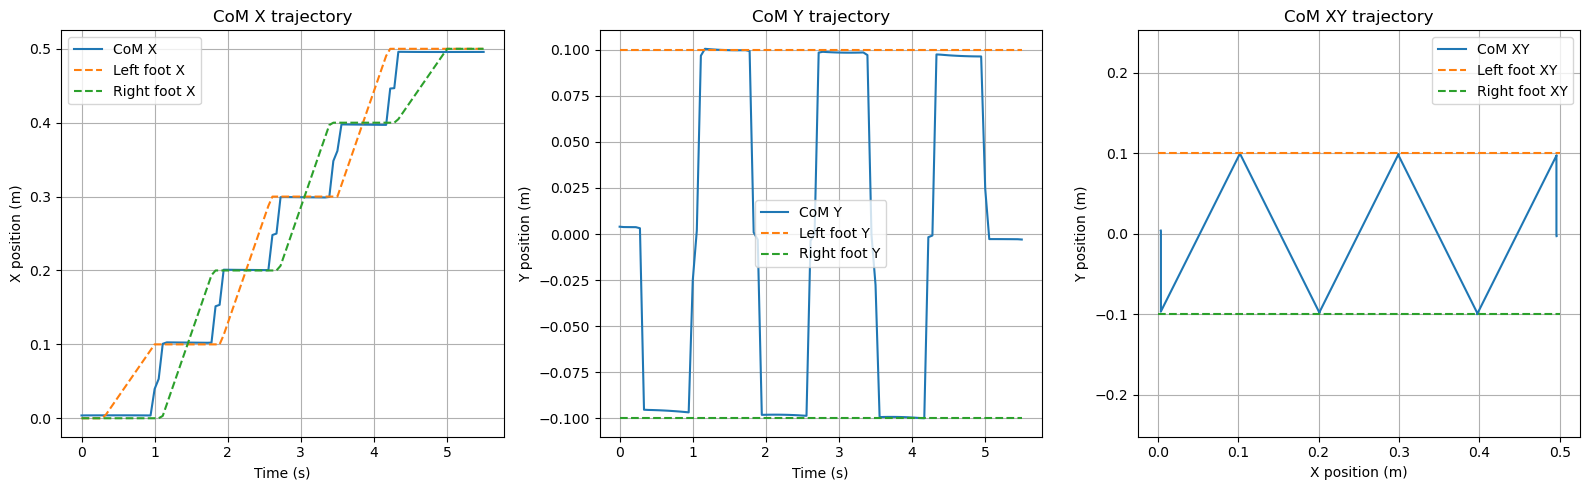

In [25]:
Plotter.plot_time_series(com_traj, left_ank, right_ank, t_total)

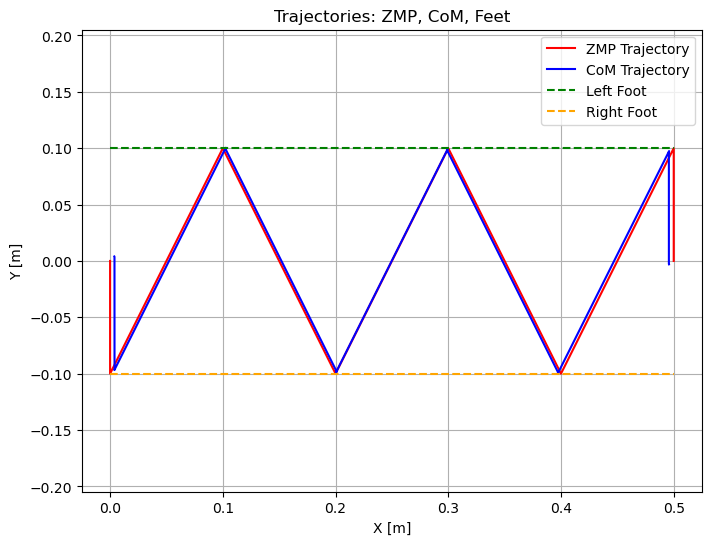

In [26]:
Plotter.plot_zmp_com_feet(zmp_traj, com_traj, left_ank, right_ank, t_total, DT)